In [1]:
from pathlib import Path
import random
import math

import numpy as np
from numba import njit

from matplotlib import pyplot as plt

### Load reference data

In [2]:
img_size = 784
img_shape = (28, 28)

train_data = np.loadtxt(Path('D:/Development/Data/datasets/csv/mnist_train_small.csv'), delimiter=',')
test_data = np.loadtxt(Path('D:/Development/Data/datasets/csv/mnist_test.csv'), delimiter=',')

### Generate dataset

In [3]:
def one_hot(n_samples: int, idx: int) -> np.ndarray:
    q = np.zeros(n_samples)
    q[idx] = 1.0
    return q

In [4]:
x_train = train_data[:,1:] / 255.0
y_train = np.array([one_hot(10, int(i)) for i in train_data[:,0]])

x_test = test_data[:,1:] / 255.0
y_test = np.array([one_hot(10, int(i)) for i in test_data[:,0]])

In [5]:
mean_x = np.zeros((10, img_size))
count_x = np.zeros(10)

for i in range(x_train.shape[0]):
    j = np.argmax(y_train[i])
    count_x[j] += 1
    mean_x[j] += x_train[i]

mean_x /= count_x.reshape((10, 1))

### Define functions

In [6]:
@njit(fastmath=True)
def norm(x: np.ndarray) -> float:
    return math.sqrt(np.sum(np.square(x)))


@njit(fastmath=True)
def normsqr(x: np.ndarray) -> float:
    return np.sum(np.square(x))


@njit(fastmath=True)
def cosim(a: np.ndarray, b: np.ndarray) -> float:
    return np.dot(a, b) / (norm(a) * norm(b))


def mcosim(m: np.ndarray, x: np.ndarray) -> np.ndarray:
    return np.dot(m, x) / (np.apply_along_axis(norm, 1, m) * norm(x))


def mmcosim(m: np.ndarray) -> np.ndarray:
    norms = np.apply_along_axis(norm, 1, m)
    return (m @ m.T) / np.outer(norms, norms)

In [7]:
@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-x))


@njit(fastmath=True)
def dsigmoid(x: np.ndarray) -> np.ndarray:
    y = sigmoid(x)
    return y * (1 - y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

In [8]:
@njit(fastmath=True)
def binary_information(y: np.ndarray) -> float:
    return -np.sum(np.log(y) + np.log(1-y))


@njit(fastmath=True)
def information(y: np.ndarray) -> float:
    return -np.sum(np.log(y))


@njit(fastmath=True)
def binary_entropy(y: np.ndarray) -> float:
    return -np.sum(y * np.log(y) + (1-y) * np.log(1-y))


@njit(fastmath=True)
def entropy(y: np.ndarray) -> float:
    return -np.sum(y * np.log(y))


@njit(fastmath=True)
def binary_cross_entropy(p: np.ndarray, q: np.ndarray) -> float:
    return -np.sum(p * np.log(q) + (1-p) * np.log(1-q))


@njit(fastmath=True)
def cross_entropy(p: np.ndarray, q: np.ndarray) -> float:
    return -np.sum(p * np.log(q))


@njit(fastmath=True)
def kl_divergence(p: np.ndarray, q: np.ndarray) -> float:
    return -np.sum(p * np.log(q/p))

In [9]:
def range_normalize(x: np.ndarray, a: float, b: float) -> np.ndarray:
    return a + (b - a) * (x - np.min(x)) / (np.max(x) - np.min(x))

### Define model

In [10]:
class Perceptron:
    def __init__(self, n_in: int, n_out: int) -> None:
        self.n_in = n_in
        self.n_out = n_out
        
        self.w: np.ndarray = np.random.uniform(-1/np.sqrt(n_in), 1/np.sqrt(n_in), (n_out, n_in))
        self.b: np.ndarray = np.zeros(n_out)

    def forward(self, x: np.ndarray) -> np.ndarray:
        return sigmoid(self.w @ x + self.b)

    def loss(self, x: np.ndarray) -> float:
        # Q = np.array([self.forward(xi) for xi in x])
        U = np.array([self.w @ xi + self.b for xi in x])
        P = np.array([softmax(u) for u in U])
        h = np.mean(np.array([binary_entropy(p) for p in P]))
        # h = np.mean(np.array([cross_entropy(p, q) for (p, q) in zip(P, Q)]))
        # h = np.mean(np.array([cross_entropy(1/self.n_out, p) for p in P]))
        # h = np.mean(np.array([binary_entropy(q) for q in Q]))
        return h

### SGD implementation

In [11]:
@njit(fastmath=True)
def grads(x_batch: np.ndarray, w: np.ndarray, b: np.ndarray, rho: float) -> tuple[np.ndarray]:
    dw = np.zeros(w.shape)
    db = np.zeros(b.shape)

    for i in range(x_batch.shape[0]):
        u = w @ x_batch[i] + b

        y = sigmoid(u) # 1

        # y = softmax(u) # 2

        # y = sigmoid(u) # 3
        # p = softmax(y) # 3

        # dLdu = y-1 # 1 (information minimization)
        # dLdu = 10*y - 1 # 2 (information minimization)
        dLdu = -y * (1-y) * np.log((1-y)/y) # 1 (binary entropy)
        # dLdu = -y * (np.sum(y*np.log(y))-np.log(y)) # 2 (entropy)
        # dLdu = -y * (np.sum(y*np.log(y/(1-y))) + np.log((1-y)/y)) # 2 (binary entropy)
        # dLdu = -p*(1-y) * (1 + y*(np.sum(p*np.log(y)) - np.log(y))) # 3 (cross-entropy)
        # dLdu = -p*(1-y) * (1 + y*(1-p)*np.log(y)) # 3 (cross-entropy) ???

        # dLdu += (1-rho)*y - rho*(1-y) # 1/2
        # dLdu += (1-rho)*p - rho*(1-p) # 3
        # dLdu = (1-p)*y - p*(1-y) # 3

        dw += np.outer(dLdu, x_batch[i])
        db += dLdu

    return (dw, db)


def train(model: Perceptron, x_train: np.ndarray, rho, lr, batch_size, max_epoch) -> None:
    n = x_train.shape[0]
    n_batches = n // batch_size

    for epoch in range(max_epoch):
        idxs = np.random.permutation(n)

        for i in range(n_batches):
            ibegin = i * batch_size
            iend = min((i + 1) * batch_size, n - 1)
            batch_idxs = idxs[ibegin:iend]

            dw, db = grads(x_train[batch_idxs], model.w, model.b, rho)

            model.w -= lr * dw/batch_size
            model.b -= lr * db/batch_size

### Create and train model

In [12]:
n_in = 784
n_out = 8
rho = 1/n_out

In [35]:
learning_rate = 1e-1
batch_size = 64
n_era = 4
n_epoch = 2

model = Perceptron(n_in, n_out)

w_old = model.w.copy()
b_old = model.b.copy()

print(model.loss(x_test))

for i in range(n_era):
    w_tmp = model.w.copy()
    b_tmp = model.b.copy()

    train(model, x_train, rho, learning_rate, batch_size, n_epoch)

    model.w = w_tmp - model.w
    model.b = b_tmp - model.b

print(model.loss(x_test))

w_new = model.w.copy()
b_new = model.b.copy()


2.9990680320565537
3.001082247054225


### Visualize weights

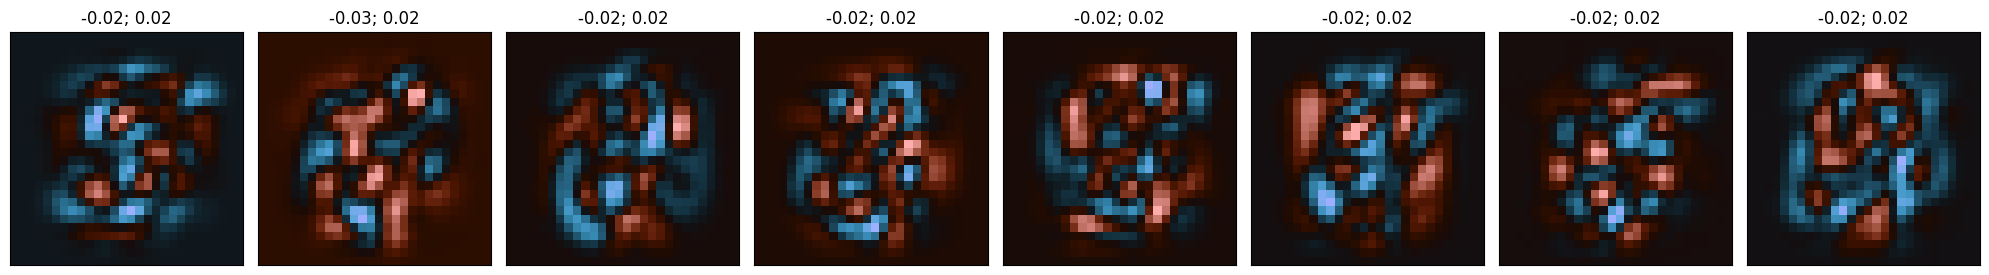

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=8)

fig.set_dpi(100)
fig.set_figwidth(20)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    w = model.w[i]
    w_norm =  range_normalize(w, -1, 1)
    img = ax.imshow(w_norm.reshape(img_shape),  cmap='berlin')
    ax.set_title(f"{round(np.min(w), 2)}; {round(np.max(w), 2)}")
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()

In [15]:
sim = mmcosim(model.w)

print(np.min(sim), np.max(sim-np.eye(n_out)), np.mean(sim-np.eye(n_out))/2)
print(np.round(sim, 2))

-0.2912325967997593 0.1694232501832463 -0.007002920228100656
[[ 1.    0.12 -0.02  0.02  0.12  0.03  0.   -0.06]
 [ 0.12  1.   -0.1   0.   -0.1   0.03 -0.02  0.1 ]
 [-0.02 -0.1   1.    0.16 -0.01  0.11 -0.29 -0.12]
 [ 0.02  0.    0.16  1.    0.17 -0.12 -0.16 -0.24]
 [ 0.12 -0.1  -0.01  0.17  1.   -0.08  0.   -0.15]
 [ 0.03  0.03  0.11 -0.12 -0.08  1.    0.01  0.12]
 [ 0.   -0.02 -0.29 -0.16  0.    0.01  1.    0.05]
 [-0.06  0.1  -0.12 -0.24 -0.15  0.12  0.05  1.  ]]


In [16]:
u_sum = np.zeros(n_out)
q_sum = np.zeros(n_out)
p_sum = np.zeros(n_out)

h = 0

for x in x_test:
    u = model.w @ x + model.b
    q = sigmoid(u)
    p = softmax(q)

    u_sum += u
    q_sum += q
    p_sum += p

    # h1_sum += entropy(q)
    # h += cross_entropy(rho, p)

print(np.round(u_sum/x_test.shape[0], 3))
print(np.round(q_sum/x_test.shape[0], 3))
print(np.round(p_sum/x_test.shape[0], 3))
# print(np.round(h/x_test.shape[0], 3))

[ 0.002  0.082 -0.04   0.16  -0.278 -0.232  0.058  0.052]
[0.5   0.52  0.49  0.54  0.431 0.442 0.514 0.513]
[0.126 0.128 0.124 0.131 0.117 0.119 0.127 0.127]


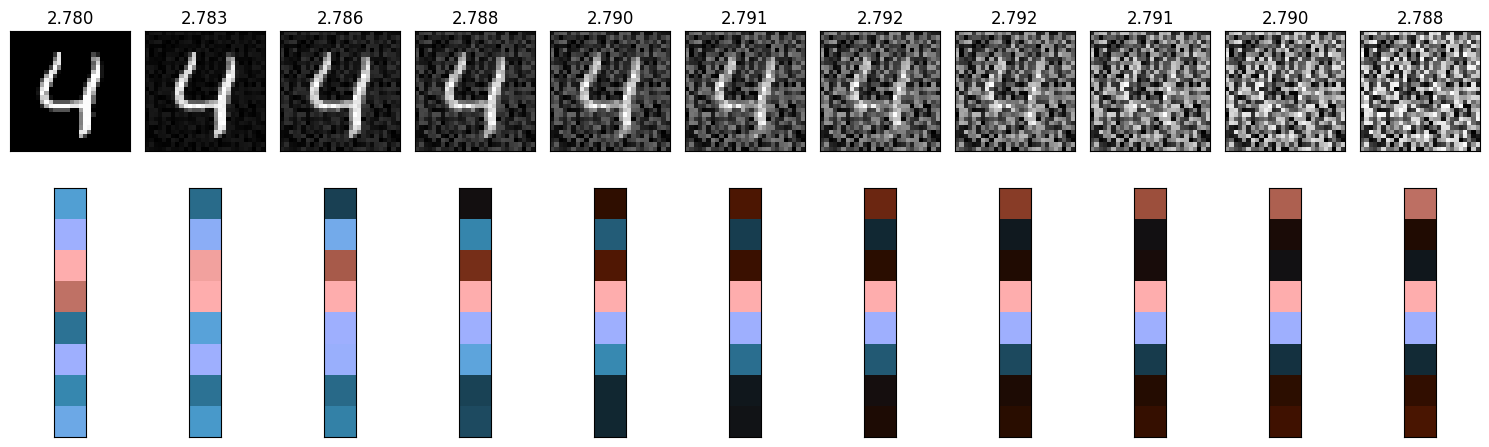

In [17]:
noise = np.random.uniform(0.0, 1.0, img_size)
n = 10
dn = 1/n

fig, axes = plt.subplots(nrows=2, ncols=n+1)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

idx = 4

for i in range(n+1):
    t = i*dn
    x = (1-t) * x_test[idx] + t * noise

    u = model.w @ x + model.b
    q = sigmoid(u)
    p = softmax(q)

    # p = softmax(u)

    # print(np.round(u, 2))
    # print(np.round(q, 2))
    # print(np.round(p, 2))

    axes[0][i].imshow(x.reshape(img_shape),  cmap='binary_r')
    # axes[1][i].matshow(range_normalize(q, 0, 1).reshape((n_out, 1)), cmap='binary_r')
    axes[1][i].matshow(range_normalize(q, 0, 1).reshape((n_out, 1)), cmap='berlin')
    
    axes[0][i].set_title(f"{entropy(q):.3f}")
    # axes[0][i].set_title(f"{cross_entropy(p, q):.3f}")

    axes[0][i].set_xticks([])
    axes[0][i].set_yticks([])

    axes[1][i].set_xticks([])
    axes[1][i].set_yticks([])

plt.tight_layout()
plt.show()


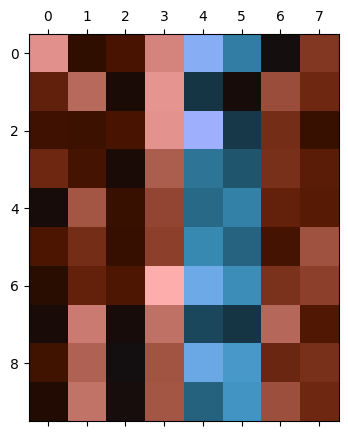

In [18]:
qs = np.zeros((10, n_out))

# w = w_old
# b = b_old

# w = w_new
# b = b_new

# w = w_new - w_old
# b = b_new - b_old

# w = w_old - w_new
# b = b_old - b_new

w = model.w
b = model.b

for i in range(10):
    u = w @ mean_x[i] + b
    q = sigmoid(u)
    p = softmax(q)

    # qs[i] = range_normalize(q, 0, 1)
    qs[i] = q.copy()
    
plt.matshow(qs, cmap='berlin')
plt.show()

In [19]:
# n_in = 784
# n_out = 10

# rho = 1/n_out
# learning_rate = 1e-2
# batch_size = 64
# max_epoch = 4

# model = Perceptron(n_in, n_out)

# w_old = model.w.copy()
# b_old = model.b.copy()

# weights = np.zeros((max_epoch, n_out, n_in))

# for i in range(max_epoch):
#     train(model, x_train, rho, learning_rate, batch_size, 1)
#     weights[i] = model.w.copy()

# fig, axes = plt.subplots(nrows=2, ncols=5)
# fig.set_dpi(100)
# fig.set_figwidth(15)
# fig.set_figheight(5)

# for i in range(max_epoch):
#     for j, ax in enumerate(axes.ravel()):
#         w_norm =  range_normalize(weights[i][j]-w_old[j], -1, 1)
#         img = ax.imshow(w_norm.reshape(img_shape),  cmap='berlin')
#         ax.set_xticks([])
#         ax.set_yticks([])
#     fig.savefig(f"D:/Development/Python/jupyter/data/images/img_{str(i).zfill(3)}.png", bbox_inches='tight')